In [1]:
import datetime
import numpy as np
import pandas as pd


from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix


In [2]:
def load_data(data_filepath):
    
    """
    Load data from flat file 
    
    Args:
        data_filepath: path where flat csv file is located
    
    Returns:
        df: dataframe of flat file
    """
        
    df = pd.read_csv(data_filepath, parse_dates = ['became_member_on'])
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    df = df.loc[df.event == 'offer received']
    
    return df

In [4]:
df = load_data('dataframe.csv')

df.head()

,event,id,time,age,became_member_on,gender,income,amount,offer_id,reward,...,difficulty,duration,offer_type,web,email,mobile,social,max_time,outcome,treatment
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75,2017-05-09,F,100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,5.0,7.0,bogo,1,1,1,0,7.0,0.0,1.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,75,2017-05-09,F,100000.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,...,0.0,3.0,informational,0,1,1,1,171.0,0.0,0.0
10,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,75,2017-05-09,F,100000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,...,10.0,7.0,bogo,0,1,1,1,415.0,0.0,1.0
12,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,75,2017-05-09,F,100000.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,...,5.0,5.0,bogo,1,1,1,1,509.0,0.0,0.0
18,offer received,a03223e636434f42ac4c3df47e8bac43,0,118,2017-08-04,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,...,20.0,10.0,discount,1,1,0,0,10.0,0.0,1.0


### Null values

In [5]:
np.sum(df.isnull()/ df.shape[0])

event               0.000000
id                  0.000000
time                0.000000
age                 0.000000
became_member_on    0.000000
gender              0.128164
income              0.128164
amount              1.000000
offer_id            0.000000
reward              1.000000
days_as_member      0.000000
difficulty          0.000000
duration            0.000000
offer_type          0.000000
web                 0.000000
email               0.000000
mobile              0.000000
social              0.000000
max_time            0.000000
outcome             0.000000
treatment           0.000000
dtype: float64

In [6]:
# rows where income and gender values are null will be dropped since it only represent ~13%.
df = df.dropna(subset=['income', 'gender'])

### Treatment and Outcome values

In [7]:
pd.crosstab(df['treatment'], df['outcome'], margins=True)

outcome,0.0,1.0,All
treatment,,,
0.0,46912,4519,51431
1.0,12207,2863,15070
All,59119,7382,66501


On an event level of analysis, there are..

* 46,912 Control Non-Responders

* 4,519 Control Responders

* 12,207 Treatment Non-Responders

* 2,863 Treatment Responders

In [8]:
# create target_class to indicate which segment event belongs to

df['target_class'] = 0 # Default set to Control Non-Responders where both treatment and outcome are 0.
df.loc[(df.treatment == 0) & (df.outcome ==1),'target_class'] = 1 # Control Responders
df.loc[(df.treatment == 1) & (df.outcome  ==0),'target_class'] = 2 # treatment Non-Responders
df.loc[(df.treatment == 1) & (df.outcome  ==1),'target_class'] = 3 # treatment Responders

In [9]:
class_dict = {0:'Control Non-Responder', 1: 'Control Responder', 2: 'Treatment Non-Responder', 3: 'Treatment Responder'}

classes = ['Control Non-Responder', 'Control Responder', 'Treatment Non-Responder', 'Treatment Responder']

In [10]:
# The value counts for the new 'target_class' match the values above.

df.target_class.value_counts()

0    46912
2    12207
1     4519
3     2863
Name: target_class, dtype: int64

### Remaining data cleaning

In [12]:
# Remaining cleaning of the data will be done to then have it ready for model building.
def clean_data(df): 
    
    """
    Perform remaning feature engineering 
    
    Args:
        df: dataframe
    
    Returns:
        df: dataframe ready for model building
    """
    # drop non-relevant features for model building purposes        
    df = df.drop(columns=['id','event', 'time', 'became_member_on', 'amount', 'offer_id', 'reward', 'max_time' ], axis=1)
    
    # subset categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
  
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    return df

clean_df = clean_data(df)

clean_df.head()

,age,income,days_as_member,difficulty,duration,web,email,mobile,social,outcome,treatment,target_class,gender_M,gender_O,offer_type_discount,offer_type_informational
0,75,100000.0,923,5.0,7.0,1,1,1,0,0.0,1.0,2,0,0,0,0
5,75,100000.0,923,0.0,3.0,0,1,1,1,0.0,0.0,0,0,0,0,1
10,75,100000.0,923,10.0,7.0,0,1,1,1,0.0,1.0,2,0,0,0,0
12,75,100000.0,923,5.0,5.0,1,1,1,1,0.0,0.0,0,0,0,0,0
29,68,70000.0,571,10.0,7.0,1,1,1,0,0.0,0.0,0,1,0,1,0


### Split train and test dataframes

In [14]:
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)

In [15]:
X_train = train_df.drop(columns=['treatment', 'outcome','target_class'], axis=1)
y_train = train_df.target_class

X_test = test_df.drop(columns=['treatment', 'outcome','target_class'], axis=1)
y_test = test_df.target_class

### Class Balance

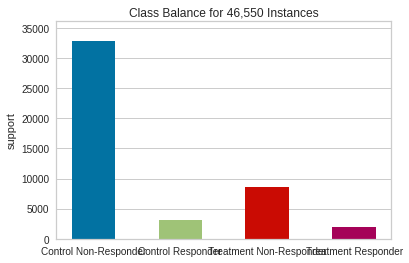

In [16]:
def class_balance(y):
    
    """
    Create yellowbrick visualization to assess Class Balance
    
    Args:
        y: target variable
    
    Returns:
        viz_show: yellowbrick ClassBalance visualization output
    """
    
    y = pd.Series(y).map(class_dict).values
    visualizer = ClassBalance(labels=classes)

    visualizer.fit(y)
    viz_show = visualizer.show()
    
    return viz_show

class_balance_viz = class_balance(y_train)

There is a class imbalance which could have negative repurcussions for training the classification model. 

An alternative training dataframe will be created that utilizes an upsampling method  to reduce the imbalance. 

### Upsampling method

In [18]:
def upsample(df, column, majority_value, minority_value):
    
    """
    
    Upsamples dataframe to address class imbalance
    
    Args:
        df: dataframe 
        column: string feature that contains class imbalance
        majority_value: value of feature that is majority
        minority_value: value of feature that is minority
    
    Returns:
        df_upsampled: Dataframe with upsampling. Note that this should only be for training data.
    """
    
    # Up-sample Minority Class approach from Elite Data Science 
    # https://elitedatascience.com/imbalanced-classes


    # Seperate majority and minority classes
    df_majority = df[df[column] == majority_value]
    df_minority = df[df[column] == minority_value]
    
    majority_n_samples = df[column].value_counts()[majority_value]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                replace=True,
                                n_samples=majority_n_samples,
                                random_state=42)

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    return df_upsampled

def upsample_train(train_df):
    
    """
    Upsamples training data and returns X and y dataframes for build_model arguements
    
    Args:
        train_df: dataframe containing training data.
    
    Returns:
        X_train: dataframe containing features to be inputted for classifier model
        y_train: dataframe containing 'target_class'
    
    """
    
    train_df_upsample = upsample(train_df, 'treatment', 0, 1)
    X_train = train_df_upsample.drop(columns=['treatment', 'outcome','target_class'], axis=1)
    y_train = train_df_upsample.target_class
    
    
    
    return X_train, y_train



X_train_upsampled, y_train_upsampled = upsample_train(train_df)

### Classifier and evaluation

In [19]:
# set clf variable
clf = RandomForestClassifier()

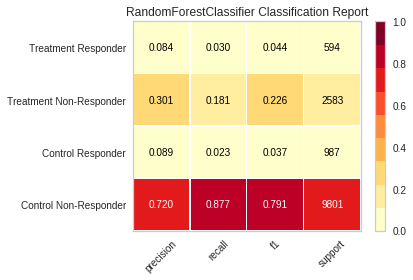

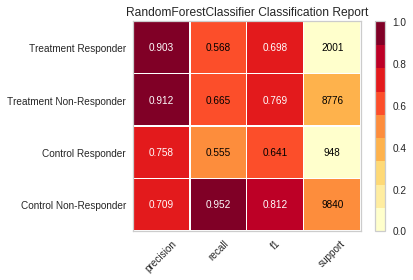

In [21]:
# compare both original training data and upsampled date in terms of classification metrics

def classification_report(X, y, model):
    
    """
    Create yellowbrick classificaiton report visualization to assess classifier performance
    
    Args:
        X: features for model building
        y: target variable
        model: Classifier model
    
    Returns:
        viz_show: yellowbrick ClassificationReport visualization output
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    
    
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
    viz_show = visualizer.show()
    
    
    
    return viz_show

classification_report_ = classification_report(X_train, y_train, clf)
classification_report_upsampled = classification_report(X_train_upsampled, y_train_upsampled, clf)

We can see in the above classification reports that the top report contains many more cells where the precision and recall is closer to 0% for the minority class. This is due to the classifier being biased toward classifiying most of all as 'Control Non-Responder', the majority class.

The bottom classification report has a much more healthy balance in terms of precision and recall across the classes and crucially for the Treatment Responder segment. 

Our business goal is to prioritize reaching out to The Treatment Responder segment so being able to increase the precision and recall for that class specifically is critical.

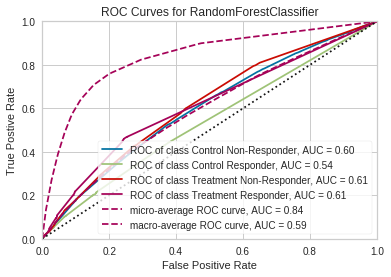

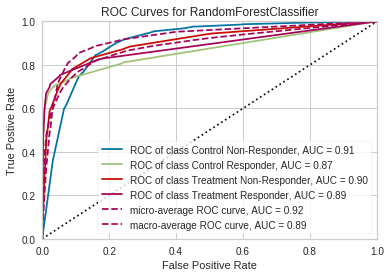

In [22]:
# visualize performance measured by Area Under the Curve ("AUC") with ROC Curves
def rocauc(X, y, model):
    
    """
    Create yellowbrick ROC Curve visualization to assess classifier performance
    
    Args:
        X: features for model building
        y: target variable
        model: Classifier model
    
    Returns:
        viz_show: yellowbrick ROCAUC visualization output
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    
    
    
    visualizer = ROCAUC(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
    viz_show = visualizer.show()
    
    
    
    return viz_show

rocauc_ = rocauc(X_train, y_train, clf)
rocauc_upsampled = rocauc(X_train_upsampled, y_train_upsampled, clf)

The ROC Curves above also illustrate how the upsampled data performs better as the climb in the True Positive Rate, measured on the y axis, happens at a much greater rate than the unsampled data.

Once again, the curve we are particularly mindful of is the burgundy ROC Curve, which measures the Treatment Responders segment. The Area Under the Curve ("AUC") for the upsampled data is 0.88 which performs much better than the unsampled data with an AUC of 0.59.

# Implementation

Due to the performance advantages of the upsampled data, the build_model.py file will include the upsample and upsample_train functions as preprocessing steps.